# py-workflowsets Demo: Multi-Model Comparison

This notebook demonstrates how to use `py-workflowsets` to efficiently compare multiple modeling approaches. WorkflowSets allow you to:

- Create cross-products of preprocessors and models
- Evaluate all workflows across resamples in parallel
- Compare and rank workflows by performance metrics
- Visualize results with automatic plotting

This is especially useful when you want to compare dozens of modeling strategies efficiently.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg
from py_rsample import vfold_cv, initial_split, training, testing
from py_yardstick import metric_set, rmse, mae, r_squared
from py_workflowsets import WorkflowSet

# Set random seed for reproducibility
np.random.seed(42)

## 1. Create Sample Data

Let's create a regression dataset with some non-linear relationships and interaction effects.

In [2]:
# Generate sample data
n = 500
X1 = np.random.randn(n)
X2 = np.random.randn(n)
X3 = np.random.randn(n)
X4 = np.random.randn(n)
X5 = np.random.randn(n)

# Create target with linear terms, interaction, and polynomial
y = (
    2.0 * X1 +           # Linear effect of X1
    3.0 * X2 +           # Linear effect of X2
    1.5 * X3 +           # Linear effect of X3
    0.5 * X1 * X2 +      # Interaction effect
    0.3 * X1**2 +        # Polynomial effect
    np.random.randn(n) * 1.0  # Noise
)

# Create DataFrame
df = pd.DataFrame({
    'x1': X1,
    'x2': X2,
    'x3': X3,
    'x4': X4,
    'x5': X5,
    'y': y
})

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset shape: (500, 6)

First few rows:


,x1,x2,x3,x4,x5,y
0,0.496714,0.926178,1.399355,0.778361,-0.675178,6.745647
1,-0.138264,1.909417,0.924634,-0.551186,-0.144519,7.680590
2,0.647689,-1.398568,0.059630,-0.818199,-0.792420,-3.469256
3,1.523030,0.562969,-0.646937,-0.003374,-0.307962,4.276921
4,-0.234153,-0.650643,0.698223,-0.170185,-1.893615,-2.365427


## 2. Create Train/Test Split

We'll use `py-rsample` to create a split for final model evaluation.

In [3]:
# Create train/test split
split = initial_split(df, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Training set: {train_data.shape[0]} rows")
print(f"Test set: {test_data.shape[0]} rows")

Training set: 375 rows
Test set: 125 rows


## 3. Define Multiple Preprocessing Strategies

We'll compare different feature engineering approaches:
- Simple linear models with different feature combinations
- Models with interaction terms
- Models with polynomial features

In [4]:
# Define different formulas (preprocessing strategies)
formulas = [
    "y ~ x1 + x2",                           # Minimal model
    "y ~ x1 + x2 + x3",                      # Add more features
    "y ~ x1 + x2 + x3 + x4 + x5",            # All features
    "y ~ x1 + x2 + x3 + I(x1*x2)",           # With interaction
    "y ~ x1 + x2 + x3 + I(x1**2) + I(x2**2)" # With polynomials
]

# Descriptive IDs for each formula
formula_ids = [
    "minimal",
    "medium",
    "full",
    "interaction",
    "polynomial"
]

print(f"Number of preprocessing strategies: {len(formulas)}")

Number of preprocessing strategies: 5


## 4. Define Multiple Model Specifications

We'll compare different linear regression approaches with varying regularization.

In [5]:
# Define different model specifications
models = [
    linear_reg(),                              # OLS
    linear_reg(penalty=0.01, mixture=1.0),     # Light Lasso
    linear_reg(penalty=0.1, mixture=1.0),      # Strong Lasso
    linear_reg(penalty=0.1, mixture=0.5),      # Elastic Net
]

print(f"Number of model specifications: {len(models)}")
print(f"\nTotal workflow combinations: {len(formulas)} × {len(models)} = {len(formulas) * len(models)}")

Number of model specifications: 4

Total workflow combinations: 5 × 4 = 20


## 5. Create WorkflowSet from Cross-Product

Now we use `WorkflowSet.from_cross()` to automatically create all combinations of preprocessors and models.

In [6]:
# Create workflow set from cross-product
wf_set = WorkflowSet.from_cross(
    preproc=formulas,
    models=models,
    ids=formula_ids
)

print(f"Created {len(wf_set)} workflows")
print(f"\nWorkflow IDs:")
for wf_id in wf_set:
    print(f"  - {wf_id}")

Created 20 workflows

Workflow IDs:
  - minimal_linear_reg_1
  - minimal_linear_reg_2
  - minimal_linear_reg_3
  - minimal_linear_reg_4
  - medium_linear_reg_1
  - medium_linear_reg_2
  - medium_linear_reg_3
  - medium_linear_reg_4
  - full_linear_reg_1
  - full_linear_reg_2
  - full_linear_reg_3
  - full_linear_reg_4
  - interaction_linear_reg_1
  - interaction_linear_reg_2
  - interaction_linear_reg_3
  - interaction_linear_reg_4
  - polynomial_linear_reg_1
  - polynomial_linear_reg_2
  - polynomial_linear_reg_3
  - polynomial_linear_reg_4


## 6. View Workflow Set Info

The `info` DataFrame contains metadata about each workflow.

In [7]:
# View workflow set information
print("Workflow Set Info:")
wf_set.info

Workflow Set Info:


,wflow_id,info,option,preprocessor,model
0,minimal_linear_reg_1,formula_linear_reg,minimal,formula,linear_reg
1,minimal_linear_reg_2,formula_linear_reg,minimal,formula,linear_reg
2,minimal_linear_reg_3,formula_linear_reg,minimal,formula,linear_reg
3,minimal_linear_reg_4,formula_linear_reg,minimal,formula,linear_reg
4,medium_linear_reg_1,formula_linear_reg,medium,formula,linear_reg
5,medium_linear_reg_2,formula_linear_reg,medium,formula,linear_reg
6,medium_linear_reg_3,formula_linear_reg,medium,formula,linear_reg
7,medium_linear_reg_4,formula_linear_reg,medium,formula,linear_reg
8,full_linear_reg_1,formula_linear_reg,full,formula,linear_reg
9,full_linear_reg_2,formula_linear_reg,full,formula,linear_reg


## 7. Set Up Cross-Validation

We'll use 5-fold cross-validation to evaluate all workflows.

In [8]:
# Create cross-validation folds
folds = vfold_cv(train_data, v=5, seed=42)

print(f"Created {folds.v} CV folds")
print(f"\nEach workflow will be evaluated {folds.v} times")
print(f"Total model fits: {len(wf_set)} workflows × {folds.v} folds = {len(wf_set) * folds.v}")

Created 5 CV folds

Each workflow will be evaluated 5 times
Total model fits: 20 workflows × 5 folds = 100


## 8. Define Evaluation Metrics

In [9]:
# Define metrics for evaluation
metrics = metric_set(rmse, mae, r_squared)

print("Evaluation metrics:")
print("  - RMSE (lower is better)")
print("  - MAE (lower is better)")
print("  - R² (higher is better)")

Evaluation metrics:
  - RMSE (lower is better)
  - MAE (lower is better)
  - R² (higher is better)


## 9. Fit All Workflows with Resampling

This is where the magic happens! `fit_resamples()` will fit all 20 workflow combinations across all 5 CV folds.

In [10]:
# Fit all workflows across all resamples
results = wf_set.fit_resamples(
    resamples=folds,
    metrics=metrics
)

print("\n" + "="*50)
print("All workflows evaluated!")
print("="*50)

Fitting minimal_linear_reg_1...
Fitting minimal_linear_reg_2...
Fitting minimal_linear_reg_3...
Fitting minimal_linear_reg_4...
Fitting medium_linear_reg_1...
Fitting medium_linear_reg_2...
Fitting medium_linear_reg_3...
Fitting medium_linear_reg_4...
Fitting full_linear_reg_1...
Fitting full_linear_reg_2...
Fitting full_linear_reg_3...
Fitting full_linear_reg_4...
Fitting interaction_linear_reg_1...
Fitting interaction_linear_reg_2...
Fitting interaction_linear_reg_3...
Fitting interaction_linear_reg_4...
Fitting polynomial_linear_reg_1...
Fitting polynomial_linear_reg_2...
Fitting polynomial_linear_reg_3...
Fitting polynomial_linear_reg_4...

All workflows evaluated!


## 10. Collect and View Metrics

Use `collect_metrics()` to aggregate results across all resamples.

In [11]:
# Collect summarized metrics (mean and std across folds)
metrics_df = results.collect_metrics(summarize=True)

print(f"Collected metrics for {len(wf_set)} workflows")
print(f"\nMetrics DataFrame shape: {metrics_df.shape}")
print(f"Expected: {len(wf_set)} workflows × 3 metrics = {len(wf_set) * 3} rows\n")

# Display first few rows
metrics_df.head(10)

Collected metrics for 20 workflows

Metrics DataFrame shape: (60, 7)
Expected: 20 workflows × 3 metrics = 60 rows



,wflow_id,metric,mean,std,n,preprocessor,model
0,full_linear_reg_1,mae,0.930254,0.059457,5,formula,linear_reg
1,full_linear_reg_1,r_squared,0.892975,0.034259,5,formula,linear_reg
2,full_linear_reg_1,rmse,1.274226,0.186860,5,formula,linear_reg
3,full_linear_reg_2,mae,0.929315,0.060066,5,formula,linear_reg
4,full_linear_reg_2,r_squared,0.893366,0.033367,5,formula,linear_reg
5,full_linear_reg_2,rmse,1.273445,0.192380,5,formula,linear_reg
6,full_linear_reg_3,mae,0.934402,0.068223,5,formula,linear_reg
7,full_linear_reg_3,r_squared,0.894050,0.026694,5,formula,linear_reg
8,full_linear_reg_3,rmse,1.282010,0.240472,5,formula,linear_reg
9,full_linear_reg_4,mae,0.947651,0.080128,5,formula,linear_reg


## 11. Rank Workflows by Performance

Use `rank_results()` to identify the best workflows.

In [12]:
# Rank workflows by RMSE (lower is better)
top_workflows = results.rank_results("rmse", n=10)

print("Top 10 Workflows by RMSE:")
print("="*80)
top_workflows

Top 10 Workflows by RMSE:


,rank,wflow_id,preprocessor,model,mae_mean,r_squared_mean,rmse_mean,mae_n,r_squared_n,rmse_n,mae_std,r_squared_std,rmse_std
4,1,interaction_linear_reg_1,formula,linear_reg,0.865180,0.911902,1.158548,5.0,5.0,5.0,0.056790,0.023017,0.107885
5,2,interaction_linear_reg_2,formula,linear_reg,0.865042,0.912019,1.158974,5.0,5.0,5.0,0.057265,0.022528,0.114782
6,3,interaction_linear_reg_3,formula,linear_reg,0.876526,0.910784,1.177820,5.0,5.0,5.0,0.068107,0.019211,0.186354
16,4,polynomial_linear_reg_1,formula,linear_reg,0.892583,0.906234,1.178070,5.0,5.0,5.0,0.041035,0.033300,0.060710
17,5,polynomial_linear_reg_2,formula,linear_reg,0.893448,0.906477,1.178818,5.0,5.0,5.0,0.039987,0.032140,0.067128
7,6,interaction_linear_reg_4,formula,linear_reg,0.886937,0.909265,1.194503,5.0,5.0,5.0,0.086081,0.016892,0.215110
18,7,polynomial_linear_reg_3,formula,linear_reg,0.907467,0.905471,1.203639,5.0,5.0,5.0,0.047761,0.023360,0.141131
19,8,polynomial_linear_reg_4,formula,linear_reg,0.920916,0.903184,1.224494,5.0,5.0,5.0,0.056844,0.019353,0.155577
8,9,medium_linear_reg_1,formula,linear_reg,0.926652,0.893833,1.269108,5.0,5.0,5.0,0.061295,0.034377,0.188092
9,10,medium_linear_reg_2,formula,linear_reg,0.926823,0.894039,1.269358,5.0,5.0,5.0,0.061404,0.033482,0.192810


## 12. Rank by R-Squared

Let's also look at the rankings by R-squared (higher is better).

In [13]:
# Rank workflows by R² (higher is better)
top_r2 = results.rank_results("r_squared", n=10)

print("Top 10 Workflows by R²:")
print("="*80)
top_r2

Top 10 Workflows by R²:


,rank,wflow_id,preprocessor,model,mae_mean,r_squared_mean,rmse_mean,mae_n,r_squared_n,rmse_n,mae_std,r_squared_std,rmse_std
5,1,interaction_linear_reg_2,formula,linear_reg,0.865042,0.912019,1.158974,5.0,5.0,5.0,0.057265,0.022528,0.114782
4,2,interaction_linear_reg_1,formula,linear_reg,0.865180,0.911902,1.158548,5.0,5.0,5.0,0.056790,0.023017,0.107885
6,3,interaction_linear_reg_3,formula,linear_reg,0.876526,0.910784,1.177820,5.0,5.0,5.0,0.068107,0.019211,0.186354
7,4,interaction_linear_reg_4,formula,linear_reg,0.886937,0.909265,1.194503,5.0,5.0,5.0,0.086081,0.016892,0.215110
17,5,polynomial_linear_reg_2,formula,linear_reg,0.893448,0.906477,1.178818,5.0,5.0,5.0,0.039987,0.032140,0.067128
16,6,polynomial_linear_reg_1,formula,linear_reg,0.892583,0.906234,1.178070,5.0,5.0,5.0,0.041035,0.033300,0.060710
18,7,polynomial_linear_reg_3,formula,linear_reg,0.907467,0.905471,1.203639,5.0,5.0,5.0,0.047761,0.023360,0.141131
19,8,polynomial_linear_reg_4,formula,linear_reg,0.920916,0.903184,1.224494,5.0,5.0,5.0,0.056844,0.019353,0.155577
10,9,medium_linear_reg_3,formula,linear_reg,0.934402,0.894050,1.282010,5.0,5.0,5.0,0.068223,0.026694,0.240472
2,10,full_linear_reg_3,formula,linear_reg,0.934402,0.894050,1.282010,5.0,5.0,5.0,0.068223,0.026694,0.240472


## 13. Visualize Results with autoplot()

The `autoplot()` method creates an automatic visualization of workflow performance.

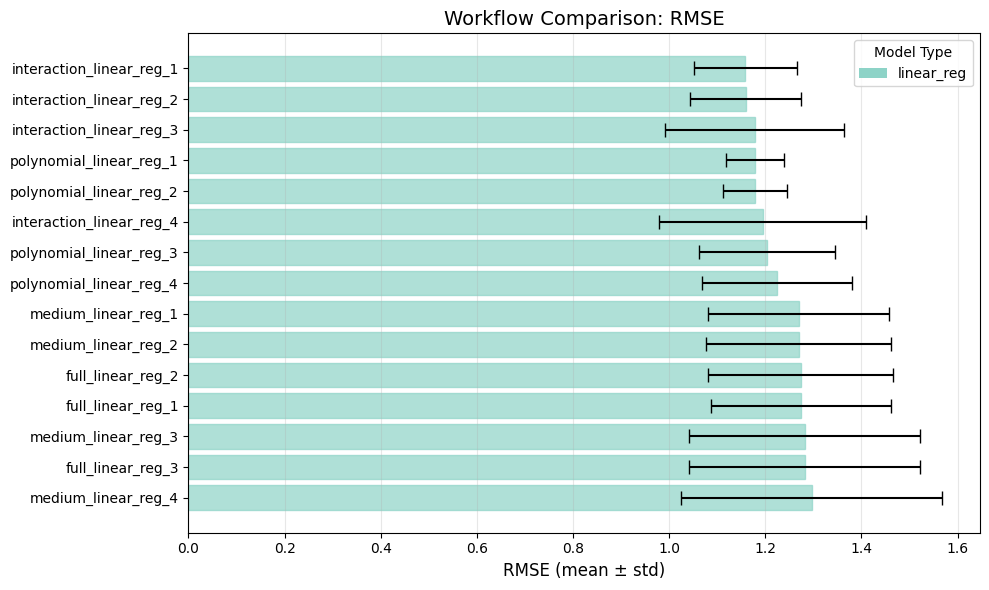


💡 Tip: Lower RMSE is better. Best models are at the top.


In [14]:
# Create visualization for RMSE
fig = results.autoplot("rmse", top_n=15)
plt.show()

print("\n💡 Tip: Lower RMSE is better. Best models are at the top.")

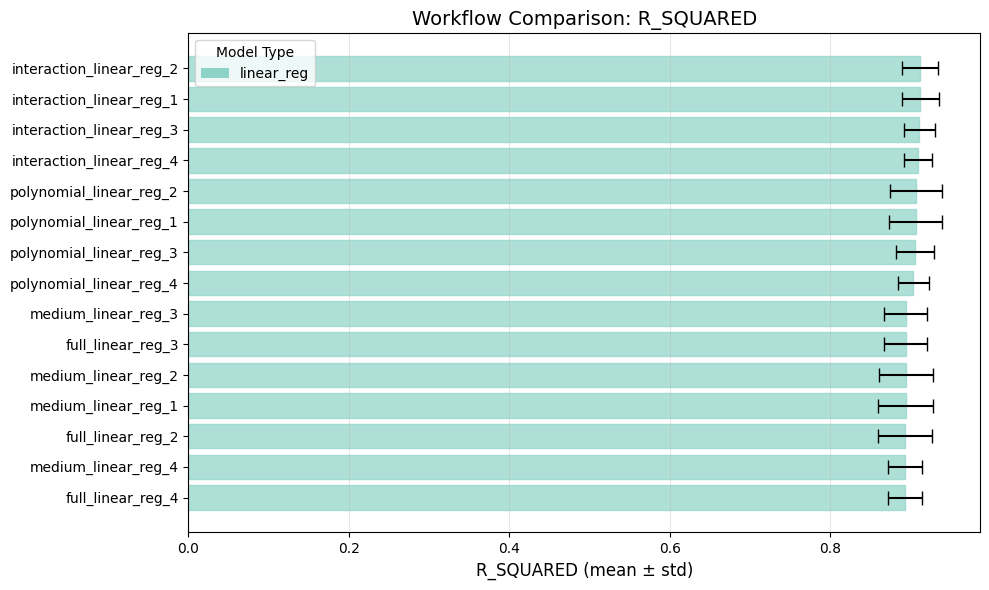


💡 Tip: Higher R² is better. Best models are at the top.


In [15]:
# Create visualization for R²
fig = results.autoplot("r_squared", top_n=15)
plt.show()

print("\n💡 Tip: Higher R² is better. Best models are at the top.")

## 14. Select Best Workflow and Evaluate on Test Set

Now let's take the best workflow and evaluate it on our held-out test set.

In [17]:
# Get the ID of the best workflow
best_wf_id = top_workflows.iloc[0]["wflow_id"]

# Get the best workflow object
best_wf = wf_set[best_wf_id]

# Fit the best workflow on full training data
print("\nFitting best workflow on full training data...")
best_wf_fitted = best_wf.fit(train_data)

# Predict on test set
test_predictions = best_wf_fitted.predict(test_data)

print("\nTest set predictions:")
test_predictions.head()


Fitting best workflow on full training data...

Test set predictions:


,.pred
0,3.332348
1,-0.798455
2,2.967221
3,3.731649
4,4.650568


In [18]:
# Calculate test set metrics
from py_yardstick import rmse, mae, r_squared

y_true = test_data['y'].values
y_pred = test_predictions['.pred'].values

test_rmse = rmse(y_true, y_pred).iloc[0]["value"]
test_mae = mae(y_true, y_pred).iloc[0]["value"]
test_r2 = r_squared(y_true, y_pred).iloc[0]["value"]

print("="*60)
print(f"Best Workflow: {best_wf_id}")
print("="*60)
print(f"Cross-Validation Performance:")
print(f"  RMSE: {top_workflows.iloc[0]['mean']:.4f} ± {top_workflows.iloc[0]['std']:.4f}")
print(f"\nTest Set Performance:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

Best Workflow: interaction_linear_reg_1
Cross-Validation Performance:


KeyError: 'mean'

## 15. Compare Cross-Validation vs Test Performance

Let's visualize how well our cross-validation estimates match the test set performance.

In [ ]:
# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions vs Actuals
ax1 = axes[0]
ax1.scatter(y_true, y_pred, alpha=0.5, s=30)
ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
         'r--', lw=2, label='Perfect predictions')
ax1.set_xlabel('Actual Values', fontsize=12)
ax1.set_ylabel('Predicted Values', fontsize=12)
ax1.set_title(f'Test Set: Predicted vs Actual\n(R² = {test_r2:.3f})', fontsize=13)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Residuals
ax2 = axes[1]
residuals = y_true - y_pred
ax2.scatter(y_pred, residuals, alpha=0.5, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Values', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title(f'Residual Plot\n(RMSE = {test_rmse:.3f})', fontsize=13)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Summary and Insights

Let's summarize what we learned from this workflow comparison.

In [ ]:
print("📊 WORKFLOW COMPARISON SUMMARY")
print("="*80)
print(f"\nTotal workflows evaluated: {len(wf_set)}")
print(f"Preprocessing strategies: {len(formulas)}")
print(f"Model specifications: {len(models)}")
print(f"CV folds per workflow: {folds.v}")
print(f"Total models fitted: {len(wf_set) * folds.v}")

print(f"\n🏆 BEST WORKFLOW")
print("="*80)
print(f"ID: {best_wf_id}")
print(f"Preprocessor: {top_workflows.iloc[0]['preprocessor']}")
print(f"Model: {top_workflows.iloc[0]['model']}")

print(f"\n📈 PERFORMANCE COMPARISON")
print("="*80)
best_cv_rmse = top_workflows.iloc[0]['mean']
best_cv_std = top_workflows.iloc[0]['std']
print(f"Cross-Validation RMSE: {best_cv_rmse:.4f} ± {best_cv_std:.4f}")
print(f"Test Set RMSE:         {test_rmse:.4f}")
print(f"Difference:            {abs(test_rmse - best_cv_rmse):.4f}")

if abs(test_rmse - best_cv_rmse) < 2 * best_cv_std:
    print("\n✅ Test performance is within 2 standard deviations of CV estimate.")
    print("   This suggests our cross-validation was reliable!")
else:
    print("\n⚠️  Test performance differs significantly from CV estimate.")
    print("   This could indicate overfitting or data shift.")

print("\n" + "="*80)

## Key Takeaways

1. **WorkflowSets are efficient**: We evaluated 20 workflow combinations with just a few lines of code

2. **Cross-product creation**: `from_cross()` automatically generates all combinations of preprocessors and models

3. **Automated evaluation**: `fit_resamples()` handles all the complexity of fitting and evaluating multiple workflows

4. **Easy comparison**: `rank_results()` and `autoplot()` make it simple to identify the best workflows

5. **Reproducible workflow**: The entire analysis is reproducible and can be easily adapted to new datasets

## Next Steps

- Try adding more preprocessing strategies (e.g., feature engineering, transformations)
- Compare different model types (e.g., linear regression vs random forest)
- Use `tune_grid()` instead of `fit_resamples()` to tune hyperparameters
- Experiment with different resampling strategies (e.g., repeated CV, bootstrap)